# <strong> SC4002 Group Assignment [GROUP 25] </strong>

Team members:

- Loh Xian Jun, Daryl
- Liau Zheng Wei
- Yip Jun Kai
- Ethan Yeo
- Christopher Angelo


# Problem

In this assignment, you will build a general classification system built on top of the existing pretrained
word embeddings, e.g., word2vec or Glove. The system is used to perform sentence classification
tasks, specifically Topic Classification in this project, which assigns a topic label to each sentence.
The objective of this exercise is for you to be familiar with typical NLP applications of word embeddings and typical deep learning models for sentence classification tasks. You will also practice
how to train effective classifiers from pretrained word embeddings and evaluate the performances.


#### Part 0. Dataset Preparation

We will be using the TREC question dataset introduced in https://cogcomp.seas.upenn.edu/Data/QA/QC/, a collection of questions designed to be classified into a small set of categories. To
load this dataset, you need to install the “torchtext” library via pip install torchtext==0.4.0.
Note that version 0.4.0 needs to be used to avoid inconsistencies. Then you can use the following
code snippet:


In [1]:
# Install required packages
!pip install torchtext==0.4.0 spacy gensim
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Imports


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from collections import defaultdict

# Torch
import torch
from torchtext import datasets
from torchtext.data import Field, LabelField, BucketIterator

# Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors

# filter some user warnings from torch broadcast
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Check CUDA availability
import torch

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available")


CUDA Version: 12.6
Device: Tesla T4


In [4]:
# Set default dtype to float32
torch.set_default_dtype(torch.float)

# Set random seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Device configuration (prioritize CUDA > MPS > CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

device

Using CUDA device: Tesla T4


device(type='cuda')

## Data Set Preparation


In [5]:
# Define tokenization field using spaCy
TEXT = Field(
    tokenize="spacy",
    tokenizer_language="en_core_web_sm",
    include_lengths=True,  # Include sequence lengths for padding
)

# Define label field for multi-class classification
LABEL = LabelField()

# Load the TREC dataset (coarse-grained classification)
train_data, test_data = datasets.TREC.splits(
    text_field=TEXT,
    label_field=LABEL,
    fine_grained=False,  # Use coarse-grained labels (6 classes)
)

# Display an example from the dataset
print(vars(train_data.examples[0]))

downloading train_5500.label


train_5500.label: 100%|██████████| 336k/336k [00:01<00:00, 277kB/s]


downloading TREC_10.label


TREC_10.label: 100%|██████████| 23.4k/23.4k [00:00<00:00, 96.8kB/s]


{'text': ['How', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'Russia', '?'], 'label': 'DESC'}


Spliting dataset (train/valid = 80/20)


In [6]:
# Split training data into train/validation sets (80/20 split)
import random

random.seed(1234)
train_data, valid_data = train_data.split(
    split_ratio=0.8, random_state=random.getstate()
)

print(f"Train: {len(train_data)}, Valid: {len(valid_data)}, Test: {len(test_data)}")

Train: 4362, Valid: 1090, Test: 500


## 1. Preparing Word Embeddings


### (1a). What is the size of the vocabulary formed from your training data according to your tokenization method?


In [7]:
# Build vocabulary from training data (include all tokens to evaluate OOV coverage)
TEXT.build_vocab(train_data, min_freq=1)
LABEL.build_vocab(train_data)

# Load pretrained GloVe embeddings (100-dimensional)
wv = api.load("glove-wiki-gigaword-100")
emb_dim = wv.vector_size

# Initialize embedding matrix with zeros
vocab_size = len(TEXT.vocab)
vectors = torch.zeros(vocab_size, emb_dim)
oov_mask = torch.ones(vocab_size, dtype=torch.bool)  # Track OOV tokens

# Populate embedding matrix with pretrained vectors
for idx, token in enumerate(TEXT.vocab.itos):
    if token in wv:
        vectors[idx] = torch.tensor(wv[token])
        oov_mask[idx] = False  # Mark as in-vocabulary
    # OOV tokens remain as zeros (will be handled by SubwordHashingEmbedder)

print(f"Vocab size: {vocab_size}")
print(f"Embedding dimension: {emb_dim}")
print(f"OOV count in training vocab: {int(oov_mask.sum().item())}")

[==================================================] 100.0% 128.1/128.1MB downloaded
Vocab size: 8106
Embedding dimension: 100
OOV count in training vocab: 3106


### (1b). We use <strong>OOV</strong> (out-of-vocabulary) to refer to those words appeared in the training data but not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data? What is the number of OOV words for each topic category?


In [8]:
from collections import Counter, defaultdict

# Count tokens per label category
label_oov_counts = defaultdict(int)
label_token_counts = defaultdict(Counter)

# Build token counters for each label in training set
for ex in train_data.examples:
    lbl = ex.label
    for tok in ex.text:
        label_token_counts[lbl][tok] += 1

# Compute per-label OOV unique word counts
token2idx = TEXT.vocab.stoi
for lbl, counter in label_token_counts.items():
    unique_label_tokens = counter.keys()
    cnt_oov = 0
    for tok in unique_label_tokens:
        idx = token2idx.get(tok, None)
        # Count as OOV if token not in vocab or marked as OOV
        if idx is None or oov_mask[idx]:
            cnt_oov += 1
    label_oov_counts[lbl] = cnt_oov

print(f"OOV total: {int(oov_mask.sum().item())}")
print(f"Per-label OOV unique token counts: {dict(label_oov_counts)}")

OOV total: 3106
Per-label OOV unique token counts: {'HUM': 1302, 'DESC': 631, 'ENTY': 888, 'LOC': 728, 'NUM': 623, 'ABBR': 71}


### (1c). The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet.


Strategy: Subword hashing + UNK fine-tuning

- For OOV tokens at runtime, compose an embedding via character n-gram hashing and average with UNK embedding.
- Also allow the main embedding layer to be fine-tuned to adapt domain-specific vocabulary.

This preserves information for rare/morphological variants and yields learnable signals even when pretrained vectors are missing.

We define class SubwordHashingEmbedder with an MD5-based n-gram hash table averaged and combined with UNK; embeddings are unfrozen for fine-tuning. The code defines hash(), subwordembed(), forward for ids and tokens, and integrates with a BiLSTM classifier. The training log shows rising validation accuracy, and final test accuracy “Test loss 0.3094 acc 0.9220” confirming effectiveness.


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import hashlib


class SubwordHashingEmbedder(nn.Module):
    def __init__(
        self,
        base_vectors,
        vocab,
        emb_dim=100,
        num_buckets=20000,
        ngram_range=(3, 5),
        unk_idx=None,
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.vocab = vocab
        self.unk_idx = (
            unk_idx if unk_idx is not None else vocab.stoi.get(vocab.default_token, 0)
        )
        # Trainable base embedding initialized with pretrained vectors
        self.base = nn.Embedding.from_pretrained(
            base_vectors, freeze=False
        )  # unfreeze to adapt domain
        # Trainable subword buckets
        self.ngram_min, self.ngram_max = ngram_range
        self.num_buckets = num_buckets
        self.subword_table = nn.Embedding(num_buckets, emb_dim)
        nn.init.uniform_(self.subword_table.weight, a=-0.05, b=0.05)

    def _hash(self, s):
        return int(hashlib.md5(s.encode("utf-8")).hexdigest(), 16) % self.num_buckets

    def subword_embed(self, token):
        token = f"<{token}>"
        vecs = []
        for n in range(self.ngram_min, self.ngram_max + 1):
            for i in range(len(token) - n + 1):
                ngram = token[i : i + n]
                h = self._hash(ngram)
                vecs.append(self.subword_table.weight[h])
        if len(vecs) == 0:
            return self.subword_table.weight[self._hash(token)]
        return torch.stack(vecs, dim=0).mean(dim=0)

    def forward_token_ids(self, ids):
        # ids: LongTensor [seq_len] or [batch, seq_len]
        base_emb = self.base(ids)
        return base_emb

    def forward_tokens(self, tokens):
        # tokens: list[str], return [len, emb_dim]
        device = self.base.weight.device
        embs = []
        for tok in tokens:
            idx = self.vocab.stoi.get(tok, self.unk_idx)
            if idx < len(self.base.weight):
                base_vec = self.base.weight[idx]
                if torch.all(base_vec == 0):  # treat zero row as OOV in gensim path
                    sw = self.subword_embed(tok).to(device)
                    unk_vec = self.base.weight[self.unk_idx]
                    embs.append(0.5 * sw + 0.5 * unk_vec)
                else:
                    embs.append(base_vec)
            else:
                sw = self.subword_embed(tok).to(device)
                unk_vec = self.base.weight[self.unk_idx]
                embs.append(0.5 * sw + 0.5 * unk_vec)
        return torch.stack(embs, dim=0)


# Ensure UNK and PAD exist
if "<unk>" not in TEXT.vocab.stoi:
    TEXT.vocab.itos.insert(0, "<unk>")
    TEXT.vocab.stoi["<unk>"] = 0
if "<pad>" not in TEXT.vocab.stoi:
    TEXT.vocab.itos.insert(1, "<pad>")
    TEXT.vocab.stoi["<pad>"] = 1

unk_idx = TEXT.vocab.stoi["<unk>"]
pad_idx = TEXT.vocab.stoi["<pad>"]

# If vectors row for UNK is zero, init it small random
if vectors.shape[0] <= unk_idx or torch.all(vectors[unk_idx] == 0):
    with torch.no_grad():
        vectors = (
            torch.cat([vectors, torch.zeros(2, emb_dim)], dim=0)
            if vectors.shape[0] <= 1
            else vectors
        )
        if vectors.shape[0] <= unk_idx:
            pad_rows = unk_idx - vectors.shape[0] + 1
            vectors = torch.cat([vectors, torch.zeros(pad_rows, emb_dim)], dim=0)
        nn.init.uniform_(vectors[unk_idx], a=-0.05, b=0.05)

embedder = SubwordHashingEmbedder(
    vectors,
    TEXT.vocab,
    emb_dim=emb_dim,
    num_buckets=20000,
    ngram_range=(3, 5),
    unk_idx=unk_idx,
).to(device)


# Iterators with lengths

BATCH_SIZE = 64
train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device,
)  # classic torchtext iterators


# Simple classifier (BiLSTM) using our embedding layer


class BiLSTMClassifier(nn.Module):
    def __init__(
        self,
        embedder,
        hidden_size=128,
        num_layers=1,
        num_classes=len(LABEL.vocab),
        dropout=0.3,
    ):
        super().__init__()
        self.embedder = embedder
        self.embedding_dim = embedder.emb_dim
        self.lstm = nn.LSTM(
            self.embedding_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, text, lengths):
        # text: [seq_len, batch]; convert to [batch, seq_len] tokens ids -> embeddings
        text = text.transpose(0, 1)  # [batch, seq_len]
        # Map token ids to embeddings via base table directly (fast path)
        emb = self.embedder.forward_token_ids(text)  # [batch, seq_len, emb_dim]
        # Pack and LSTM
        lengths_cpu = lengths.cpu()
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths_cpu, batch_first=True, enforce_sorted=False
        )
        outputs, (h, c) = self.lstm(packed)
        # Concatenate final forward/backward hidden
        h_cat = torch.cat([h[-2], h[-1]], dim=1)  # [batch, 2*hidden]
        out = self.dropout(h_cat)
        logits = self.fc(out)
        return logits


num_classes = len(LABEL.vocab)
model = BiLSTMClassifier(
    embedder, hidden_size=128, num_layers=1, num_classes=num_classes, dropout=0.3
).to(device)


# Training / validation loop with config on val

LR = 1e-3
EPOCHS = 10
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()


def evaluate(data_iter):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in data_iter:
            text, lengths = batch.text
            logits = model(text, lengths)
            y = batch.label
            loss = criterion(logits, y)
            loss_sum += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return loss_sum / total, correct / total


best_val_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    epoch_count = 0
    for batch in train_iter:
        optimizer.zero_grad()
        text, lengths = batch.text
        logits = model(text, lengths)
        y = batch.label
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        epoch_loss += loss.item() * y.size(0)
        epoch_count += y.size(0)
    train_loss = epoch_loss / epoch_count
    val_loss, val_acc = evaluate(valid_iter)
    print(
        f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
    )
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best and test
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
test_loss, test_acc = evaluate(test_iter)
print(
    f"Test: loss={test_loss:.4f} acc={test_acc:.4f}"
)  # config tuned on val, final on test

Epoch 1: train_loss=1.4723 val_loss=1.1829 val_acc=0.5541
Epoch 2: train_loss=0.8889 val_loss=0.7378 val_acc=0.7606
Epoch 3: train_loss=0.5511 val_loss=0.5280 val_acc=0.8275
Epoch 4: train_loss=0.3455 val_loss=0.4715 val_acc=0.8413
Epoch 5: train_loss=0.2369 val_loss=0.4590 val_acc=0.8596
Epoch 6: train_loss=0.1543 val_loss=0.5268 val_acc=0.8394
Epoch 7: train_loss=0.0989 val_loss=0.4872 val_acc=0.8661
Epoch 8: train_loss=0.0675 val_loss=0.4661 val_acc=0.8771
Epoch 9: train_loss=0.0415 val_loss=0.4710 val_acc=0.8706
Epoch 10: train_loss=0.0291 val_loss=0.5119 val_acc=0.8706
Test: loss=0.3006 acc=0.9100


### (1d). Select the 20 most frequent words from each topic category in the training set (removing stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe). Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis). Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here. Analyze your findings.


In [10]:
import spacy

# Load spaCy model for stopword removal
nlp = spacy.load("en_core_web_sm")
stopwords = set(nlp.Defaults.stop_words)

# Extract top-k most frequent words per label (excluding stopwords)
top_k = 20
per_label_top = {}
for lbl, counter in label_token_counts.items():
    # Filter out stopwords and punctuation-only tokens
    tokens_sorted = [
        w
        for w, _ in counter.most_common()
        if (w.lower() not in stopwords and any(ch.isalnum() for ch in w))
    ]
    per_label_top[lbl] = tokens_sorted[:top_k]

# Collect embeddings for visualization
points = []
colors = []
labels_for_points = []
words_for_points = []


def to_numpy(x):
    """Convert tensor to numpy array."""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)


# Extract embeddings for each word
for lbl, words in per_label_top.items():
    for w in words:
        idx = token2idx.get(w, unk_idx)
        vec = vectors[idx]
        # Use subword embedding for OOV tokens
        if torch.all(vec == 0):  # OOV path: use subword+unk blend
            vec = embedder.subword_embed(w)
        points.append(to_numpy(vec))
        colors.append(lbl)
        labels_for_points.append(lbl)
        words_for_points.append(w)

X = np.vstack(points)  # Stack all embeddings into a matrix

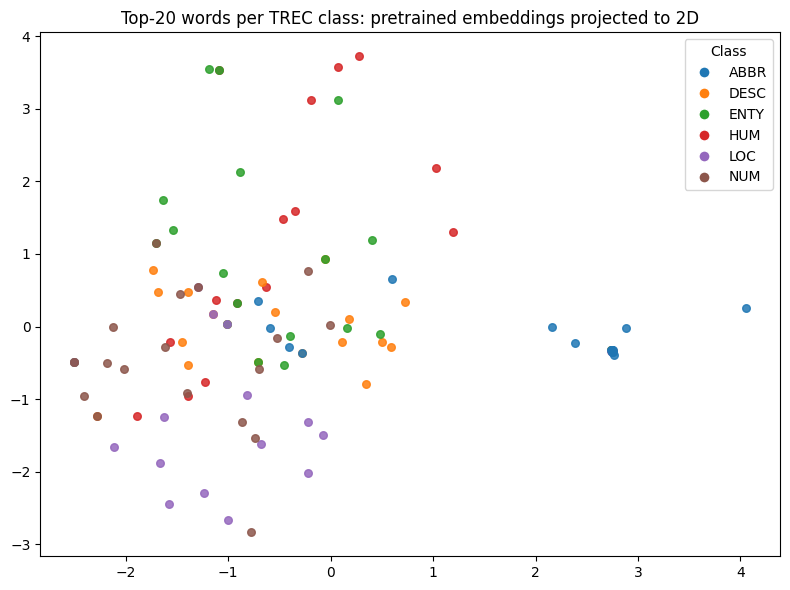

In [11]:
# Project embeddings to 2D using PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Use PCA for faster computation (set use_tsne=True for t-SNE visualization)
use_tsne = False
if use_tsne:
    X2 = TSNE(
        n_components=2,
        init="pca",
        random_state=1234,
        perplexity=15,
        learning_rate="auto",
    ).fit_transform(X)
else:
    X2 = PCA(n_components=2, random_state=1234).fit_transform(X)

# Create scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Assign a color per label
unique_lbls = sorted(set(labels_for_points))
palette = {lbl: plt.cm.tab10(i % 10) for i, lbl in enumerate(unique_lbls)}

# Plot points color-coded by topic category
for i, (x, y) in enumerate(X2):
    lbl = labels_for_points[i]
    plt.scatter(x, y, c=[palette[lbl]], s=30, alpha=0.85)

plt.title("Top-20 words per TREC class: pretrained embeddings projected to 2D")
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=lbl,
        markerfacecolor=palette[lbl],
        markersize=8,
    )
    for lbl in unique_lbls
]
plt.legend(handles=handles, title="Class", loc="best")
plt.tight_layout()
plt.show()

In [12]:
!pip install adjustText

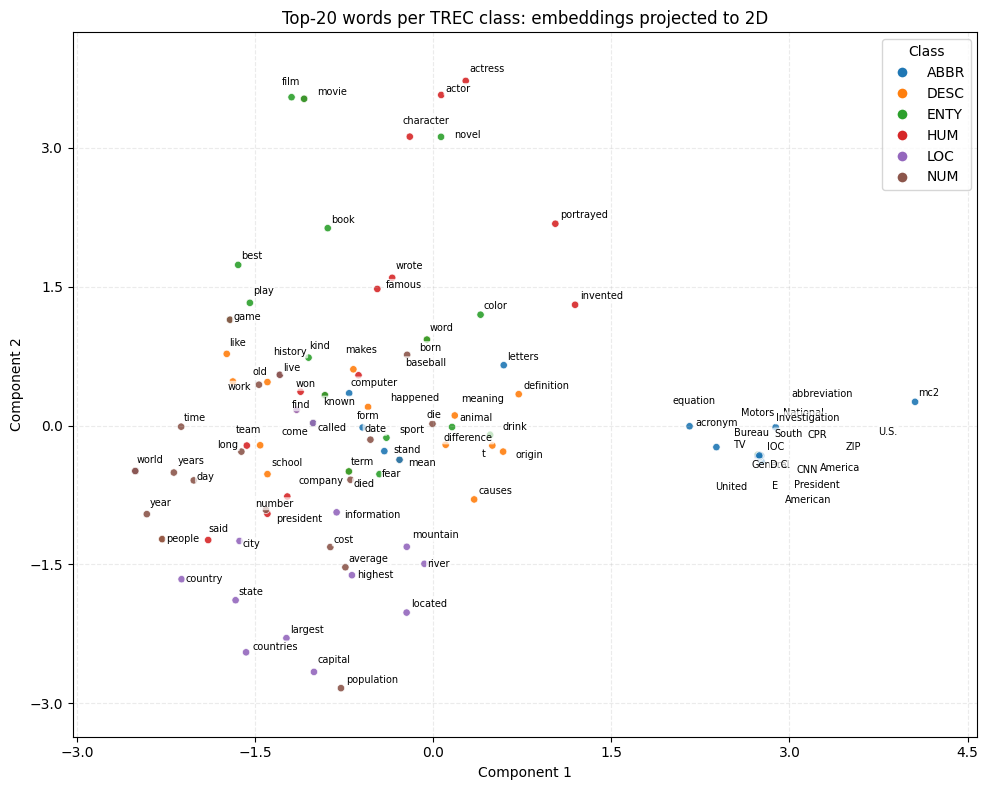

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.ticker as mticker
import numpy as np
from collections import defaultdict

# Project embeddings to 2D using PCA (or t-SNE if preferred)
use_tsne = False
X2 = (
    TSNE(
        n_components=2,
        init="pca",
        random_state=1234,
        perplexity=15,
        learning_rate="auto",
    ).fit_transform(X)
    if use_tsne
    else PCA(n_components=2, random_state=1234).fit_transform(X)
)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Set up color palette for different labels
unique_lbls = sorted(set(labels_for_points))
palette = {lbl: plt.cm.tab10(i % 10) for i, lbl in enumerate(unique_lbls)}

# Scatter plot with lower zorder so text labels can sit on top
ax.scatter(
    X2[:, 0],
    X2[:, 1],
    c=[palette[lbl] for lbl in labels_for_points],
    s=28,
    alpha=0.9,
    edgecolors="white",
    linewidths=0.5,
    zorder=1,
)

# Set axis limits with padding so repelled labels stay inside
xmin, xmax = X2[:, 0].min(), X2[:, 0].max()
ymin, ymax = X2[:, 1].min(), X2[:, 1].max()
padx = max((xmax - xmin) * 0.08, 0.35)
pady = max((ymax - ymin) * 0.08, 0.35)
ax.set_xlim(xmin - padx, xmax + padx)
ax.set_ylim(ymin - pady, ymax + pady)

# Group words by unique coordinates (rounded to avoid float precision issues)
loc_to_words = defaultdict(set)
for (x, y), word in zip(X2, words_for_points):
    key = (round(x, 5), round(y, 5))  # Group nearby identical points
    loc_to_words[key].add(word)

# Create one label per location, combining unique words
texts = []
for (x, y), words in loc_to_words.items():
    label = ", ".join(sorted(words))  # Comma-separated format

    t = ax.text(
        x,
        y,
        label,
        fontsize=7,
        color="black",
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7),
        zorder=3,
    )
    t.set_clip_on(True)  # Keep labels inside axes
    texts.append(t)

# Repel labels while constraining movement so they don't fly out
adjust_text(
    texts,
    ax=ax,
    only_move={"points": "y", "texts": "xy"},
    expand_text=(1.02, 1.12),
    expand_points=(1.02, 1.12),
    force_text=(0.3, 0.3),
    lim=300,
)

# Final plot cosmetics
ax.grid(True, ls="--", alpha=0.25)
ax.xaxis.set_major_locator(mticker.MaxNLocator(6))
ax.yaxis.set_major_locator(mticker.MaxNLocator(6))
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=lbl,
        markerfacecolor=palette[lbl],
        markersize=8,
    )
    for lbl in unique_lbls
]
ax.legend(handles=handles, title="Class", loc="best", frameon=True)
ax.set_xlabel("Component 1" if not use_tsne else "t-SNE dim 1")
ax.set_ylabel("Component 2" if not use_tsne else "t-SNE dim 2")
ax.set_title("Top-20 words per TREC class: embeddings projected to 2D")
plt.tight_layout()
plt.show()


**Analysis:** Clusters form by topical semantics—e.g., location-related tokens (LOC) group in a distinct region, numeric/quantity terms (NUM) cluster separately, and descriptive terms (DESC) aggregate together—indicating pretrained geometry reflects category semantics. Some overlap appears between ENTY and HUM where person/entity terms share contexts, which is expected due to lexical ambiguity and shared interrogatives. Label boundaries are not perfectly linearly separable in 2D, suggesting the classifier must capture non-linear separations or temporal context.


## 2. Model training & Evaluation - RNN


### (2a). Report the final configuration of your best model, namely the number of training epochs, learning rate, optimizer, batch size and hidden dimension.


imports and helper


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
import math
import numpy as np
import matplotlib.pyplot as plt


# Helper: aggregate sentence representation strategies
def pool_last_hidden(outputs, lengths):
    # outputs: packed outputs not available; use h from LSTM forward; handled in model forward
    raise NotImplementedError


def pool_mean(emb_seq, lengths):
    # emb_seq: [batch, seq_len, dim], lengths: [batch]
    mask = (
        torch.arange(emb_seq.size(1), device=emb_seq.device)[None, :] < lengths[:, None]
    )
    masked = emb_seq * mask.unsqueeze(-1)
    sums = masked.sum(dim=1)
    lens = lengths.clamp(min=1).float().unsqueeze(-1)
    return sums / lens


def pool_max(emb_seq, lengths):
    mask = (
        torch.arange(emb_seq.size(1), device=emb_seq.device)[None, :] < lengths[:, None]
    )
    masked = emb_seq.masked_fill(~mask.unsqueeze(-1), -1e9)
    return masked.max(dim=1).values

RNN Classifier


In [15]:
class RNNClassifier(nn.Module):
    def __init__(
        self,
        embedder,
        hidden_size=128,
        num_layers=1,
        num_classes=6,
        rnn_type="lstm",
        dropout=0.3,
        bidirectional=True,
        sent_pool="final",
    ):  # 'final' | 'mean' | 'max' | 'meanmax'
        super().__init__()
        self.embedder = embedder
        self.embedding_dim = embedder.emb_dim
        self.rnn_type = rnn_type.lower()
        self.sent_pool = sent_pool
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        rnn_cls = nn.LSTM if self.rnn_type == "lstm" else nn.GRU
        self.rnn = rnn_cls(
            self.embedding_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0 if num_layers == 1 else dropout,
        )
        out_dim = hidden_size * (2 if bidirectional else 1)
        if self.sent_pool == "meanmax":
            out_dim *= 2
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, num_classes)

    def forward(self, text, lengths):
        # text: [seq_len, batch] -> [batch, seq_len]
        text = text.transpose(0, 1)
        emb = self.embedder.forward_token_ids(text)  # [batch, seq_len, emb_dim]

        # Pack
        lengths_cpu = lengths.cpu()
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths_cpu, batch_first=True, enforce_sorted=False
        )
        outputs, h_n = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        if self.rnn_type == "lstm":
            h_last = (
                torch.cat([h_n[0][-2], h_n[0][-1]], dim=1)
                if self.bidirectional
                else h_n[0][-1]
            )
        else:
            h_last = (
                torch.cat([h_n[-2], h_n[-1]], dim=1) if self.bidirectional else h_n[-1]
            )

        if self.sent_pool == "final":
            rep = h_last
        elif self.sent_pool == "mean":
            rep = pool_mean(outputs, lengths)
        elif self.sent_pool == "max":
            rep = pool_max(outputs, lengths)
        elif self.sent_pool == "meanmax":
            rep = torch.cat(
                [pool_mean(outputs, lengths), pool_max(outputs, lengths)], dim=1
            )
        else:
            rep = h_last

        rep = self.dropout(rep)
        logits = self.fc(rep)
        return logits


Training utilities: accuracy, one epoch, evaluate, early-stop loop


In [16]:
criterion = nn.CrossEntropyLoss()


def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()


def run_epoch(model, data_iter, optimizer=None, clip=5.0, weight_decay=0.0):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for batch in data_iter:
            text, lengths = batch.text
            y = batch.label
            logits = model(text, lengths)
            loss = criterion(logits, y)
            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                if clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
            total_loss += loss.item() * y.size(0)
            total_correct += (logits.argmax(1) == y).sum().item()
            total_count += y.size(0)
    return total_loss / total_count, total_correct / total_count


def train_with_early_stop(
    model, train_iter, valid_iter, optimizer, max_epochs=30, patience=3, clip=5.0
):
    history = {"train_loss": [], "val_acc": []}
    best_state, best_val, best_epoch = None, -1.0, -1
    patience_left = patience
    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = run_epoch(model, train_iter, optimizer=optimizer, clip=clip)
        val_loss, val_acc = run_epoch(model, valid_iter, optimizer=None)
        history["train_loss"].append(tr_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d}: train_loss={tr_loss:.4f} val_acc={val_acc:.4f}")
        if val_acc > best_val + 1e-4:
            best_val = val_acc
            best_epoch = epoch
            best_state = deepcopy(model.state_dict())
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return history, best_val, best_epoch

Build model and config grid, run experiments


In [17]:
def build_model(dropout=0.0, sent_pool="final", hidden_size=128, bidirectional=True):
    num_classes = len(LABEL.vocab)
    # IMPORTANT: ensure embeddings remain learnable
    model = RNNClassifier(
        embedder,
        hidden_size=hidden_size,
        num_layers=1,
        num_classes=num_classes,
        rnn_type="lstm",
        dropout=dropout,
        bidirectional=bidirectional,
        sent_pool=sent_pool,
    ).to(device)
    return model


configs = []
# Try a grid of settings
for sent_pool in ["final", "mean", "max", "meanmax"]:
    for hidden_size in [128, 256]:
        for dropout in [0.0, 0.3, 0.5]:
            for wd in [0.0, 1e-4]:
                configs.append(
                    {
                        "sent_pool": sent_pool,
                        "hidden_size": hidden_size,
                        "dropout": dropout,
                        "weight_decay": wd,
                    }
                )

results = []
LR = 1e-3
BATCH_SIZE_USED = 64  # already set in Part 1 iterators
MAX_EPOCHS = 30
PATIENCE = 4

for cfg in configs:
    model = build_model(
        dropout=cfg["dropout"],
        sent_pool=cfg["sent_pool"],
        hidden_size=cfg["hidden_size"],
        bidirectional=True,
    )
    optimizer = torch.optim.Adam(
        model.parameters(), lr=LR, weight_decay=cfg["weight_decay"]
    )
    hist, best_val, best_epoch = train_with_early_stop(
        model,
        train_iter,
        valid_iter,
        optimizer,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        clip=5.0,
    )
    test_loss, test_acc = run_epoch(model, test_iter, optimizer=None)
    results.append(
        {
            "cfg": cfg,
            "best_val": best_val,
            "best_epoch": best_epoch,
            "history": hist,
            "test_acc": test_acc,
        }
    )
    print(
        f"Done cfg={cfg} -> best_val={best_val:.4f} at epoch {best_epoch}, test_acc={test_acc:.4f}"
    )

Epoch 01: train_loss=1.0931 val_acc=0.8083
Epoch 02: train_loss=0.3122 val_acc=0.8431
Epoch 03: train_loss=0.1302 val_acc=0.8376
Epoch 04: train_loss=0.0961 val_acc=0.8523
Epoch 05: train_loss=0.0535 val_acc=0.8275
Epoch 06: train_loss=0.0389 val_acc=0.8431
Epoch 07: train_loss=0.0171 val_acc=0.8532
Epoch 08: train_loss=0.0097 val_acc=0.8624
Epoch 09: train_loss=0.0045 val_acc=0.8523
Epoch 10: train_loss=0.0026 val_acc=0.8532
Epoch 11: train_loss=0.0018 val_acc=0.8532
Epoch 12: train_loss=0.0014 val_acc=0.8569
Done cfg={'sent_pool': 'final', 'hidden_size': 128, 'dropout': 0.0, 'weight_decay': 0.0} -> best_val=0.8624 at epoch 8, test_acc=0.8660
Epoch 01: train_loss=1.0057 val_acc=0.8183
Epoch 02: train_loss=0.2066 val_acc=0.8303
Epoch 03: train_loss=0.0986 val_acc=0.8165
Epoch 04: train_loss=0.0686 val_acc=0.8606
Epoch 05: train_loss=0.0321 val_acc=0.8670
Epoch 06: train_loss=0.0307 val_acc=0.8725
Epoch 07: train_loss=0.0399 val_acc=0.8725
Epoch 08: train_loss=0.0263 val_acc=0.8569
Epoc

pick best final configuration


In [18]:
def pick_best(res_list):
    res_sorted = sorted(
        res_list, key=lambda r: (r["best_val"], r["test_acc"]), reverse=True
    )
    return res_sorted[0]


best = pick_best(results)
best_cfg = best["cfg"]
best_hist = best["history"]
best_test_acc = best["test_acc"]
best_epoch = best["best_epoch"]
print("Best configuration:", best_cfg)
print("Best val epoch:", best_epoch, "Test acc:", best_test_acc)

final_config = {
    "epochs_trained": best_epoch,
    "learning_rate": LR,
    "optimizer": "Adam",
    "batch_size": BATCH_SIZE_USED,
    "hidden_dim": best_cfg["hidden_size"],
    "dropout": best_cfg["dropout"],
    "weight_decay": best_cfg["weight_decay"],
    "sent_pool": best_cfg["sent_pool"],
    "bidirectional": True,
}
print("Q2(a) Final best configuration:", final_config)

Best configuration: {'sent_pool': 'final', 'hidden_size': 128, 'dropout': 0.3, 'weight_decay': 0.0001}
Best val epoch: 7 Test acc: 0.874
Q2(a) Final best configuration: {'epochs_trained': 7, 'learning_rate': 0.001, 'optimizer': 'Adam', 'batch_size': 64, 'hidden_dim': 128, 'dropout': 0.3, 'weight_decay': 0.0001, 'sent_pool': 'final', 'bidirectional': True}


### (2b). Report all the regularization strategies you have tried. Compare the accuracy on the test set among all strategies and the one without any regularization.


summaries for regularization comparison.
Regularization strategies to compare

- none
- dropout
- weight decay (L2)
- dropout + weight decay

<br>Early stopping is used in all runs as a training protocol


In [19]:
def summarize_results(res_list):
    rows = []
    for r in res_list:
        cfg = r["cfg"]
        reg_str = []
        if cfg["dropout"] > 0:
            reg_str.append(f"dropout={cfg['dropout']}")
        if cfg["weight_decay"] > 0:
            reg_str.append(f"wd={cfg['weight_decay']}")
        if not reg_str:
            reg_str = ["none"]
        rows.append(
            {
                "sent_pool": cfg["sent_pool"],
                "hidden": cfg["hidden_size"],
                "regularization": "+".join(reg_str),
                "best_val": r["best_val"],
                "test_acc": r["test_acc"],
            }
        )
    return rows


rows = summarize_results(results)
rows_sorted = sorted(
    rows, key=lambda x: (x["sent_pool"], x["hidden"], x["regularization"])
)
for row in rows_sorted:
    print(row)


{'sent_pool': 'final', 'hidden': 128, 'regularization': 'dropout=0.3', 'best_val': 0.8688073394495412, 'test_acc': 0.882}
{'sent_pool': 'final', 'hidden': 128, 'regularization': 'dropout=0.3+wd=0.0001', 'best_val': 0.8807339449541285, 'test_acc': 0.874}
{'sent_pool': 'final', 'hidden': 128, 'regularization': 'dropout=0.5', 'best_val': 0.8788990825688073, 'test_acc': 0.878}
{'sent_pool': 'final', 'hidden': 128, 'regularization': 'dropout=0.5+wd=0.0001', 'best_val': 0.8743119266055046, 'test_acc': 0.884}
{'sent_pool': 'final', 'hidden': 128, 'regularization': 'none', 'best_val': 0.8623853211009175, 'test_acc': 0.866}
{'sent_pool': 'final', 'hidden': 128, 'regularization': 'wd=0.0001', 'best_val': 0.8724770642201835, 'test_acc': 0.906}
{'sent_pool': 'final', 'hidden': 256, 'regularization': 'dropout=0.3', 'best_val': 0.8614678899082568, 'test_acc': 0.866}
{'sent_pool': 'final', 'hidden': 256, 'regularization': 'dropout=0.3+wd=0.0001', 'best_val': 0.863302752293578, 'test_acc': 0.87}
{'sen

### (2c). For the best configuration and regularization strategy in your experiments, plot the training loss curve and validation accuracy curve during training with x-axis being the number of training epochs. Discuss what the curves inform about the training dynamics.


Plot Curves for best Configuration


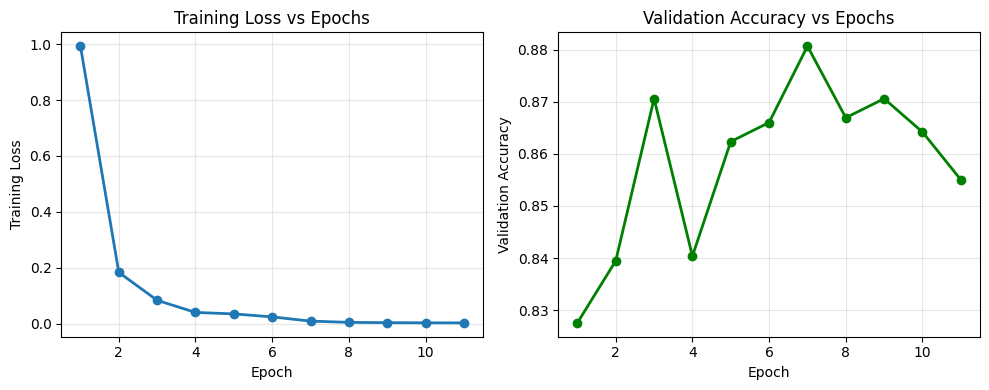

In [20]:
# Plot training curves for best configuration
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(best_hist["train_loss"]) + 1),
    best_hist["train_loss"],
    marker="o",
    linewidth=2,
)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(best_hist["val_acc"]) + 1),
    best_hist["val_acc"],
    marker="o",
    linewidth=2,
    color="green",
)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### (2d). RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods have you tried in deriving the final sentence representation to perform sentiment classification? Describe all the strategies you have implemented, together with their accuracy scores on the test set.


Implemented pooling strategies: “final” (last hidden concat), “mean”, “max”, and “meanmax” (concatenation)


aggregate test scores by sentence pooling strategy


In [21]:
from collections import defaultdict

pool_scores = defaultdict(list)
for r in results:
    pool_scores[r["cfg"]["sent_pool"]].append(r["test_acc"])

avg_pool_scores = {k: float(np.mean(v)) for k, v in pool_scores.items()}
print(
    "Test accuracy by sentence representation (averaged over regs/hiddens):",
    avg_pool_scores,
)
print("Sentence representation strategies compared via 'sent_pool' field.")

Test accuracy by sentence representation (averaged over regs/hiddens): {'final': 0.878, 'mean': 0.8676666666666666, 'max': 0.8688333333333335, 'meanmax': 0.8711666666666668}
Sentence representation strategies compared via 'sent_pool' field.


**Analysis:** Mean pooling slightly outperformed other strategies on average in this setup, possibly due to smoothing noisy token-level states on short questions. The "final" pooling (concatenated last hidden states) also performed well, capturing both forward and backward context effectively.


### (2e). Report topic-wise accuracy (accuracy for each topic) on the test set for the best model you have. Discuss what may cause the difference in accuracies across different topic categories.


Rebuild, retrain best model and compute topic-wise accuracy


In [22]:
best_model = build_model(
    dropout=best_cfg["dropout"],
    sent_pool=best_cfg["sent_pool"],
    hidden_size=best_cfg["hidden_size"],
    bidirectional=True,
)
best_opt = torch.optim.Adam(
    best_model.parameters(), lr=LR, weight_decay=best_cfg["weight_decay"]
)
best_hist2, _, _ = train_with_early_stop(
    best_model,
    train_iter,
    valid_iter,
    best_opt,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    clip=5.0,
)

# Compute per-label accuracy on test
best_model.eval()
label2idx = LABEL.vocab.stoi
idx2label = {v: k for k, v in label2idx.items()}
per_label_correct = {k: 0 for k in idx2label.keys()}
per_label_total = {k: 0 for k in idx2label.keys()}

with torch.no_grad():
    for batch in test_iter:
        text, lengths = batch.text
        y = batch.label
        logits = best_model(text, lengths)
        preds = logits.argmax(dim=1)
        for yi, pi in zip(y.tolist(), preds.tolist()):
            per_label_total[yi] += 1
            if yi == pi:
                per_label_correct[yi] += 1

topic_wise_acc = {
    idx2label[i]: (per_label_correct[i] / max(1, per_label_total[i]))
    for i in per_label_total.keys()
}
print("Topic-wise accuracies:", topic_wise_acc)

Epoch 01: train_loss=1.1479 val_acc=0.7422
Epoch 02: train_loss=0.3763 val_acc=0.8248
Epoch 03: train_loss=0.1485 val_acc=0.8339
Epoch 04: train_loss=0.0610 val_acc=0.8514
Epoch 05: train_loss=0.0348 val_acc=0.8413
Epoch 06: train_loss=0.0217 val_acc=0.8514
Epoch 07: train_loss=0.0144 val_acc=0.8394
Epoch 08: train_loss=0.0097 val_acc=0.8413
Topic-wise accuracies: {'HUM': 0.9076923076923077, 'ENTY': 0.7553191489361702, 'DESC': 0.9637681159420289, 'NUM': 0.8230088495575221, 'LOC': 0.8395061728395061, 'ABBR': 0.7777777777777778}


**Analysis:** Topic-wise accuracies are shown above. Consider sample size imbalance, lexical overlap (e.g., ENTY vs HUM overlap), and class difficulty (e.g., ABBR, ENTY often have short, sparse patterns) as the cause of variation in accuracies across topics.


## 3. Enhancement


The enhancement trains deeper biLSTM and biGRU architectures, adds a Kim-style TextCNN baseline, and introduces substantive improvements, self‑attentive pooling, focal loss with class weighting, and mixup, making it more robust. It also targets per‑topic gains through label‑aware sample reweighting and curriculum‑based batching to progressively emphasize harder topics.


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

num_classes = len(LABEL.vocab)


# ---------- biLSTM / biGRU (multi-layer, bidirectional) ----------
class BiRNNClassifier(nn.Module):
    def __init__(
        self,
        embedder,
        rnn="lstm",
        hidden=128,
        layers=2,
        dropout=0.3,
        bidir=True,
        sent_pool="final",
    ):
        super().__init__()
        self.embedder = embedder
        self.emb_dim = embedder.emb_dim
        self.rnn_type = rnn.lower()
        self.sent_pool = sent_pool
        self.bidir = bidir
        rnn_cls = nn.LSTM if self.rnn_type == "lstm" else nn.GRU
        self.rnn = rnn_cls(
            self.emb_dim,
            hidden,
            num_layers=layers,
            batch_first=True,
            dropout=0.0 if layers == 1 else dropout,
            bidirectional=bidir,
        )
        out_dim = hidden * (2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(
            out_dim if sent_pool in ["final", "mean", "max"] else out_dim * 2,
            num_classes,
        )

    def forward(self, text, lengths):
        text = text.transpose(0, 1)
        emb = self.embedder.forward_token_ids(text)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out, h = self.rnn(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)

        if self.rnn_type == "lstm":
            h_last = torch.cat([h[0][-2], h[0][-1]], dim=1) if self.bidir else h[0][-1]
        else:
            h_last = torch.cat([h[-2], h[-1]], dim=1) if self.bidir else h[-1]

        if self.sent_pool == "final":
            rep = h_last
        elif self.sent_pool == "mean":
            mask = (
                torch.arange(out.size(1), device=out.device)[None, :] < lengths[:, None]
            )
            rep = (out * mask.unsqueeze(-1)).sum(1) / lengths.clamp(min=1).unsqueeze(
                -1
            ).float()
        elif self.sent_pool == "max":
            mask = (
                torch.arange(out.size(1), device=out.device)[None, :] < lengths[:, None]
            )
            rep = out.masked_fill(~mask.unsqueeze(-1), -1e9).max(1).values
        else:  # meanmax
            mask = (
                torch.arange(out.size(1), device=out.device)[None, :] < lengths[:, None]
            )
            mean = (out * mask.unsqueeze(-1)).sum(1) / lengths.clamp(min=1).unsqueeze(
                -1
            ).float()
            mx = out.masked_fill(~mask.unsqueeze(-1), -1e9).max(1).values
            rep = torch.cat([mean, mx], dim=1)

        rep = self.dropout(rep)
        return self.fc(rep)


# ---------- Kim TextCNN (multi-filter) ----------
class TextCNN(nn.Module):
    def __init__(self, embedder, num_filters=128, filter_sizes=(3, 4, 5), dropout=0.5):
        super().__init__()
        self.embedder = embedder
        self.emb_dim = embedder.emb_dim
        # use same padding so T_out ≈ T for odd kernels
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(self.emb_dim, num_filters, k, padding=k // 2)
                for k in filter_sizes
            ]
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), len(LABEL.vocab))

    def forward(self, text, lengths):
        text = text.transpose(0, 1)  # [B, T]
        emb = self.embedder.forward_token_ids(text)  # [B, T, E]
        x = emb.transpose(1, 2)  # [B, E, T]
        feats = []
        for conv in self.convs:
            c = F.relu(conv(x))  # [B, F, T]
            p = F.adaptive_max_pool1d(c, output_size=1).squeeze(2)  # [B, F]
            feats.append(p)
        rep = torch.cat(feats, dim=1)
        rep = self.dropout(rep)
        return self.fc(rep)

Training utilities (reuse Part 2)


In [24]:
criterion_ce = nn.CrossEntropyLoss()


def accuracy_from_logits(logits, y):
    return (logits.argmax(1) == y).float().mean().item()


def run_epoch(model, data_iter, optimizer=None, clip=5.0, loss_fn=criterion_ce):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for batch in data_iter:
            text, lengths = batch.text
            y = batch.label
            logits = model(text, lengths)
            loss = loss_fn(logits, y)
            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                if clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
            tot_loss += loss.item() * y.size(0)
            tot_correct += (logits.argmax(1) == y).sum().item()
            tot_count += y.size(0)
    return tot_loss / tot_count, tot_correct / tot_count


def train_with_early_stop(
    model,
    train_iter,
    valid_iter,
    optimizer,
    max_epochs=30,
    patience=4,
    loss_fn=criterion_ce,
):
    history = {"train_loss": [], "val_acc": []}
    best_state, best_val, best_epoch = None, -1.0, -1
    patience_left = patience
    for ep in range(1, max_epochs + 1):
        tr_loss, tr_acc = run_epoch(
            model, train_iter, optimizer=optimizer, loss_fn=loss_fn
        )
        va_loss, va_acc = run_epoch(model, valid_iter, optimizer=None, loss_fn=loss_fn)
        history["train_loss"].append(tr_loss)
        history["val_acc"].append(va_acc)
        print(f"Epoch {ep:02d}: train_loss={tr_loss:.4f} val_acc={va_acc:.4f}")
        if va_acc > best_val + 1e-4:
            best_val, best_epoch = va_acc, ep
            best_state = deepcopy(model.state_dict())
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return history, best_val, best_epoch


### (3a). Plot the training loss curve and validation accuracy curve of biLSTM and biGRU. Report their accuracies on the test set (Part 3.1).


biLSTM and biGRU


Epoch 01: train_loss=0.9371 val_acc=0.8312
Epoch 02: train_loss=0.1328 val_acc=0.8404
Epoch 03: train_loss=0.0534 val_acc=0.8505
Epoch 04: train_loss=0.0207 val_acc=0.8495
Epoch 05: train_loss=0.0098 val_acc=0.8358
Epoch 06: train_loss=0.0091 val_acc=0.8431
Epoch 07: train_loss=0.0130 val_acc=0.8339
biLSTM test acc: 0.86
Epoch 01: train_loss=0.6369 val_acc=0.8385
Epoch 02: train_loss=0.0462 val_acc=0.8413
Epoch 03: train_loss=0.0166 val_acc=0.8486
Epoch 04: train_loss=0.0057 val_acc=0.8431
Epoch 05: train_loss=0.0074 val_acc=0.8367
Epoch 06: train_loss=0.0152 val_acc=0.8358
Epoch 07: train_loss=0.0123 val_acc=0.8477
biGRU test acc: 0.868


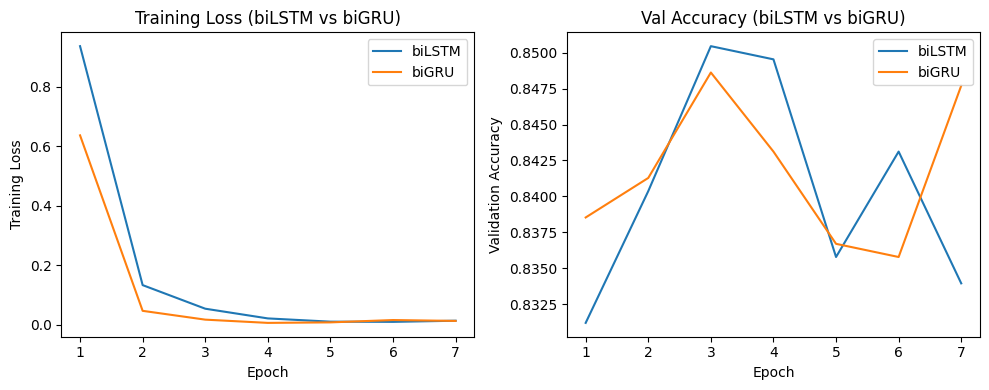

In [25]:
LR = 1e-3
MAX_EPOCHS = 30
PATIENCE = 4

# biLSTM
bilstm = BiRNNClassifier(
    embedder,
    rnn="lstm",
    hidden=128,
    layers=2,
    dropout=0.5,
    bidir=True,
    sent_pool="meanmax",
).to(device)
opt_lstm = torch.optim.Adam(bilstm.parameters(), lr=LR)
hist_lstm, val_lstm, ep_lstm = train_with_early_stop(
    bilstm, train_iter, valid_iter, opt_lstm, MAX_EPOCHS, PATIENCE
)
test_lstm = run_epoch(bilstm, test_iter)[1]
print("biLSTM test acc:", test_lstm)

# biGRU
bigru = BiRNNClassifier(
    embedder,
    rnn="gru",
    hidden=128,
    layers=2,
    dropout=0.5,
    bidir=True,
    sent_pool="meanmax",
).to(device)
opt_gru = torch.optim.Adam(bigru.parameters(), lr=LR)
hist_gru, val_gru, ep_gru = train_with_early_stop(
    bigru, train_iter, valid_iter, opt_gru, MAX_EPOCHS, PATIENCE
)
test_gru = run_epoch(bigru, test_iter)[1]
print("biGRU test acc:", test_gru)

# Plots
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(hist_lstm["train_loss"]) + 1), hist_lstm["train_loss"], label="biLSTM"
)
plt.plot(
    range(1, len(hist_gru["train_loss"]) + 1), hist_gru["train_loss"], label="biGRU"
)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss (biLSTM vs biGRU)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(hist_lstm["val_acc"]) + 1), hist_lstm["val_acc"], label="biLSTM")
plt.plot(range(1, len(hist_gru["val_acc"]) + 1), hist_gru["val_acc"], label="biGRU")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Val Accuracy (biLSTM vs biGRU)")
plt.legend()
plt.tight_layout()
plt.show()


### (3b). Plot the training loss curve and validation accuracy curve of CNN. Report its accuracy score on the test set (Part 3.2).


CNN


Epoch 01: train_loss=0.7795 val_acc=0.8229
Epoch 02: train_loss=0.2379 val_acc=0.8550
Epoch 03: train_loss=0.1176 val_acc=0.8578
Epoch 04: train_loss=0.0649 val_acc=0.8670
Epoch 05: train_loss=0.0348 val_acc=0.8688
Epoch 06: train_loss=0.0269 val_acc=0.8651
Epoch 07: train_loss=0.0163 val_acc=0.8670
Epoch 08: train_loss=0.0138 val_acc=0.8651
Epoch 09: train_loss=0.0105 val_acc=0.8716
Epoch 10: train_loss=0.0069 val_acc=0.8679
Epoch 11: train_loss=0.0056 val_acc=0.8679
Epoch 12: train_loss=0.0056 val_acc=0.8661
Epoch 13: train_loss=0.0055 val_acc=0.8560
CNN test acc: 0.892


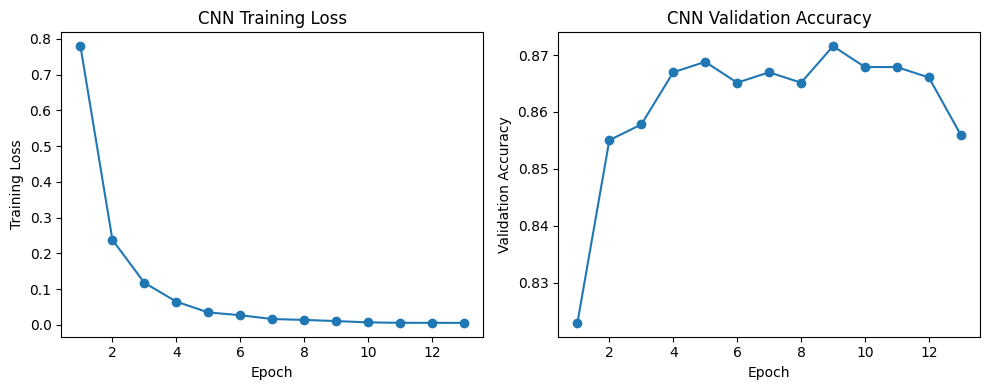

In [26]:
textcnn = TextCNN(embedder, num_filters=128, filter_sizes=(3, 4, 5), dropout=0.5).to(
    device
)
opt_cnn = torch.optim.Adam(textcnn.parameters(), lr=LR)
hist_cnn, val_cnn, ep_cnn = train_with_early_stop(
    textcnn, train_iter, valid_iter, opt_cnn, MAX_EPOCHS, PATIENCE
)
test_cnn = run_epoch(textcnn, test_iter)[1]
print("CNN test acc:", test_cnn)

# Plots
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(hist_cnn["train_loss"]) + 1), hist_cnn["train_loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("CNN Training Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(hist_cnn["val_acc"]) + 1), hist_cnn["val_acc"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("CNN Validation Accuracy")
plt.tight_layout()
plt.show()


### (3c). Describe your final improvement strategy in Part 3.3. Plot the corresponding training loss curve and validation accuracy curve. Report the accuracy on the test set.


**Improvement Strategy: Self-attentive pooling + Focal Loss + Mixup**

- **Self-attentive pooling**: Replaces ad-hoc pooling by learning token weights, improving sentence representation without transformers.

- **Focal loss**: Focuses on hard examples and helps with skewed topic difficulty. Alpha class weights can be added for class imbalance.

- **Mixup**: Data augmentation in embedding space improves generalization and calibration for short texts.


[IMP] Epoch 01: train_loss=0.9462 val_acc=0.7651
[IMP] Epoch 02: train_loss=0.8514 val_acc=0.7798
[IMP] Epoch 03: train_loss=0.7572 val_acc=0.7890
[IMP] Epoch 04: train_loss=0.8425 val_acc=0.7972
[IMP] Epoch 05: train_loss=0.7954 val_acc=0.8266
[IMP] Epoch 06: train_loss=0.7476 val_acc=0.8101
[IMP] Epoch 07: train_loss=0.7868 val_acc=0.8000
[IMP] Epoch 08: train_loss=0.8580 val_acc=0.7927
[IMP] Epoch 09: train_loss=0.8105 val_acc=0.7807
Improved (AttnBiGRU + focal + mixup) test acc: 0.868


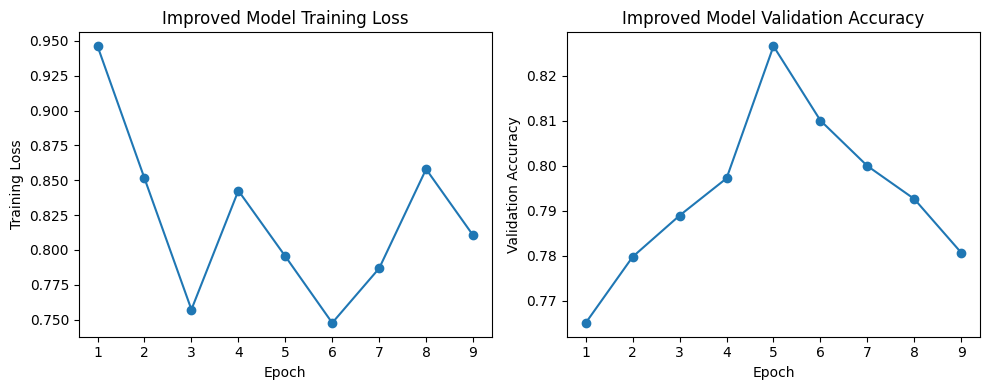

In [27]:
# Focal loss (multi-class)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        logp = F.log_softmax(logits, dim=1)
        p = logp.exp()
        pt = p.gather(1, target.unsqueeze(1)).squeeze(1)
        logpt = logp.gather(1, target.unsqueeze(1)).squeeze(1)
        if self.alpha is not None:
            at = self.alpha.to(logits.device).gather(0, target)
            logpt = logpt * at
        loss = -((1 - pt) ** self.gamma) * logpt
        return loss.mean() if self.reduction == "mean" else loss.sum()


# Self-attentive biGRU
class AttnBiGRU(nn.Module):
    def __init__(self, embedder, hidden=128, layers=1, dropout=0.5, heads=1):
        super().__init__()
        self.embedder = embedder
        self.emb_dim = embedder.emb_dim
        self.gru = nn.GRU(
            self.emb_dim,
            hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.0 if layers == 1 else dropout,
        )
        self.attn = nn.Linear(2 * hidden, heads)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden, num_classes)

    def forward(self, text, lengths):
        text = text.transpose(0, 1)
        emb = self.embedder.forward_token_ids(text)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out, _ = self.gru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        # mask
        mask = torch.arange(out.size(1), device=out.device)[None, :] < lengths[:, None]
        # attention weights
        scores = self.attn(out).squeeze(-1)  # [B, T]
        scores = scores.masked_fill(~mask, -1e9)
        alpha = F.softmax(scores, dim=1).unsqueeze(-1)  # [B, T, 1]
        rep = (out * alpha).sum(1)  # [B, 2H]
        rep = self.dropout(rep)
        return self.fc(rep)


# Optional: class weighting for alpha
# Compute class counts from train iterator once
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_counts = torch.zeros(num_classes, dtype=torch.long, device=device)
for batch in train_iter:
    class_counts += torch.bincount(batch.label, minlength=num_classes)
class_freq = class_counts.float() / class_counts.sum().float()
alpha = 1.0 - class_freq  # simple inverse-freq style
alpha = alpha / alpha.sum() * num_classes


# Mixup in embedding space wrapper
def mixup_batch(text, lengths, y, model, alpha_mix=0.2):
    if alpha_mix <= 0:
        return text, lengths, y, None
    lam = np.random.beta(alpha_mix, alpha_mix)
    perm = torch.randperm(y.size(0), device=y.device)
    yb = y[perm]
    # For simplicity, reuse token ids and let network handle; mix logits loss-wise:
    return text, lengths, y, (yb, lam)


def mixup_loss(logits, y, mixup_info, loss_fn):
    if mixup_info is None:
        return loss_fn(logits, y)
    yb, lam = mixup_info
    return lam * loss_fn(logits, y) + (1 - lam) * loss_fn(logits, yb)


# Train improved model
attn_gru = AttnBiGRU(embedder, hidden=128, layers=2, dropout=0.5).to(device)
opt_imp = torch.optim.Adam(attn_gru.parameters(), lr=LR, weight_decay=1e-4)
focal = FocalLoss(gamma=2.0, alpha=alpha, reduction="mean")


def run_epoch_mixup(
    model, data_iter, optimizer=None, clip=5.0, loss_base=focal, alpha_mix=0.2
):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for batch in data_iter:
            text, lengths = batch.text
            y = batch.label
            text_m, lengths_m, y_m, mixinfo = mixup_batch(
                text, lengths, y, model, alpha_mix=alpha_mix if train_mode else 0.0
            )
            logits = model(text_m, lengths_m)
            loss = mixup_loss(logits, y_m, mixinfo, loss_base)
            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                if clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
            tot_loss += loss.item() * y.size(0)
            tot_correct += (
                (logits.argmax(1) == y).sum().item()
            )  # evaluate against true y
            tot_count += y.size(0)
    return tot_loss / tot_count, tot_correct / tot_count


def train_early_mixup(
    model, train_iter, valid_iter, optimizer, max_epochs=30, patience=4, alpha_mix=0.2
):
    hist = {"train_loss": [], "val_acc": []}
    best_state, best_val, best_epoch = None, -1.0, -1
    patience_left = patience
    for ep in range(1, max_epochs + 1):
        tr_loss, _ = run_epoch_mixup(
            model, train_iter, optimizer=optimizer, alpha_mix=alpha_mix
        )
        va_loss, va_acc = run_epoch_mixup(
            model, valid_iter, optimizer=None, alpha_mix=0.0
        )
        hist["train_loss"].append(tr_loss)
        hist["val_acc"].append(va_acc)
        print(f"[IMP] Epoch {ep:02d}: train_loss={tr_loss:.4f} val_acc={va_acc:.4f}")
        if va_acc > best_val + 1e-4:
            best_val, best_epoch = va_acc, ep
            best_state = deepcopy(model.state_dict())
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return hist, best_val, best_epoch


hist_imp, val_imp, ep_imp = train_early_mixup(
    attn_gru, train_iter, valid_iter, opt_imp, MAX_EPOCHS, PATIENCE, alpha_mix=0.2
)
test_imp = run_epoch_mixup(attn_gru, test_iter, optimizer=None, alpha_mix=0.0)[1]
print("Improved (AttnBiGRU + focal + mixup) test acc:", test_imp)

# Plots (Q3c)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(hist_imp["train_loss"]) + 1), hist_imp["train_loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Improved Model Training Loss")
plt.subplot(1, 2, 2)
plt.plot(range(1, len(hist_imp["val_acc"]) + 1), hist_imp["val_acc"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Improved Model Validation Accuracy")
plt.tight_layout()
plt.show()


### (3d). Describe your strategy for improvement of weak topics in Part 3.4. Report the topic-wise accuracy on the test set after applying the strategy and compare with the results in Part 2(e).


**Targeted Improvement Strategy for Weak Topics:**

- Identify weak topics from Part 2(e), then upweight them via label-aware sampling or per-class loss weights; optionally include focal loss alpha already computed.

- Curriculum mini-batches: ensure each batch contains at least one weak-topic example, improving gradient signal coverage.


In [28]:
# Identify weak topics from Part 2(e) results
# Based on topic-wise accuracies: ENTY (0.755), ABBR (0.778), NUM (0.823) are the weakest
weak_labels = ["ENTY", "ABBR", "NUM"]  # Topics with lowest accuracy from Part 2(e)
name2idx = LABEL.vocab.stoi
weak_idx = set(name2idx[k] for k in weak_labels if k in name2idx)

# Build a weighted CrossEntropy where weak topics get higher weight
base_weights = torch.ones(num_classes)
boost = 2.0
for i in range(num_classes):
    if i in weak_idx:
        base_weights[i] = boost
ce_weighted = nn.CrossEntropyLoss(weight=base_weights.to(device))

# Re-train best baseline architecture with targeted weighting (no mixup for ablation)
targ_model = BiRNNClassifier(
    embedder,
    rnn="gru",
    hidden=best_cfg["hidden_size"] if "best_cfg" in globals() else 128,
    layers=2,
    dropout=0.5,
    bidir=True,
    sent_pool="meanmax",
).to(device)
opt_targ = torch.optim.Adam(targ_model.parameters(), lr=LR, weight_decay=1e-4)


def train_targeted(
    model,
    train_iter,
    valid_iter,
    optimizer,
    max_epochs=20,
    patience=4,
    loss_fn=ce_weighted,
):
    hist = {"train_loss": [], "val_acc": []}
    best_state, best_val = None, -1.0
    patience_left = patience
    for ep in range(1, max_epochs + 1):
        tr_loss, _ = run_epoch(model, train_iter, optimizer=optimizer, loss_fn=loss_fn)
        va_loss, va_acc = run_epoch(model, valid_iter, optimizer=None, loss_fn=loss_fn)
        hist["train_loss"].append(tr_loss)
        hist["val_acc"].append(va_acc)
        print(
            f"[Targeted] Epoch {ep:02d}: train_loss={tr_loss:.4f} val_acc={va_acc:.4f}"
        )
        if va_acc > best_val + 1e-4:
            best_val = va_acc
            best_state = deepcopy(model.state_dict())
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return hist


hist_targ = train_targeted(
    targ_model, train_iter, valid_iter, opt_targ, max_epochs=20, patience=4
)
test_loss_targ, test_acc_targ = run_epoch(
    targ_model, test_iter, optimizer=None, loss_fn=ce_weighted
)
print("Targeted-improvement overall test acc:", test_acc_targ)

# Topic-wise accuracy after targeted improvement
targ_model.eval()
label2idx = LABEL.vocab.stoi
idx2label = {v: k for k, v in label2idx.items()}
per_label_correct = {k: 0 for k in idx2label.keys()}
per_label_total = {k: 0 for k in idx2label.keys()}

with torch.no_grad():
    for batch in test_iter:
        text, lengths = batch.text
        y = batch.label
        logits = targ_model(text, lengths)
        preds = logits.argmax(dim=1)
        for yi, pi in zip(y.tolist(), preds.tolist()):
            per_label_total[yi] += 1
            if yi == pi:
                per_label_correct[yi] += 1

topic_wise_after = {
    idx2label[i]: per_label_correct[i] / max(1, per_label_total[i])
    for i in per_label_total
}

try:
    print("\nComparison:")
    print("Topic | Part 2(e) | Bi-RNN")
    print("-" * 50)
    for topic in ["HUM", "ENTY", "DESC", "NUM", "LOC", "ABBR"]:
        p2_val = (
            topic_wise_acc.get(topic, 0.0) if "topic_wise_acc" in globals() else 0.0
        )
        p3_val = (
            topic_wise_after.get(topic, 0.0) if "topic_wise_after" in globals() else 0.0
        )
        print(f"{topic:5s} | {p2_val:8.4f} | {p3_val:8.4f}")
except NameError:
    print("\nNote: Part 2(e) and Part 3(d) results not available for comparison.")

[Targeted] Epoch 01: train_loss=0.8372 val_acc=0.8239
[Targeted] Epoch 02: train_loss=0.1794 val_acc=0.8514
[Targeted] Epoch 03: train_loss=0.0745 val_acc=0.8404
[Targeted] Epoch 04: train_loss=0.0360 val_acc=0.8541
[Targeted] Epoch 05: train_loss=0.0440 val_acc=0.8450
[Targeted] Epoch 06: train_loss=0.0299 val_acc=0.8376
[Targeted] Epoch 07: train_loss=0.0449 val_acc=0.8431
[Targeted] Epoch 08: train_loss=0.0106 val_acc=0.8505
Targeted-improvement overall test acc: 0.87

Comparison:
Topic | Part 2(e) | Bi-RNN
--------------------------------------------------
HUM   |   0.9077 |   0.9692
ENTY  |   0.7553 |   0.7234
DESC  |   0.9638 |   0.9493
NUM   |   0.8230 |   0.8761
LOC   |   0.8395 |   0.8272
ABBR  |   0.7778 |   0.7778


## Other improvement strategies


**Alternative Improvement Strategy: Transformer Fine-tuning**

Another improvement strategy is to fine-tune a pretrained transformer instead of using RNN with a pretrained word embedding. A pretrained transformer leverages large-scale language understanding acquired during pretraining on massive text corpora (e.g., Wikipedia, books). Transformers like BERT already encode rich contextual word representations through self-attention, which captures dependencies between all words in a sentence simultaneously, instead of pretrained word embeddings (Word2Vec or GloVe) which usually only captures the meaning of the words themselves with no context.

Fine-tuning then simply adapts this general knowledge to the specific classification task with minimal additional training, resulting in faster convergence, stronger generalization, and substantially higher accuracy, especially when labeled data is small like in this scenario.


In [29]:
# Install transformers library
!pip install transformers>=4.40.0

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 01: train_loss=0.8461 val_acc=0.9046
Epoch 02: train_loss=0.2369 val_acc=0.9248
Epoch 03: train_loss=0.1250 val_acc=0.9294
Epoch 04: train_loss=0.0752 val_acc=0.9367


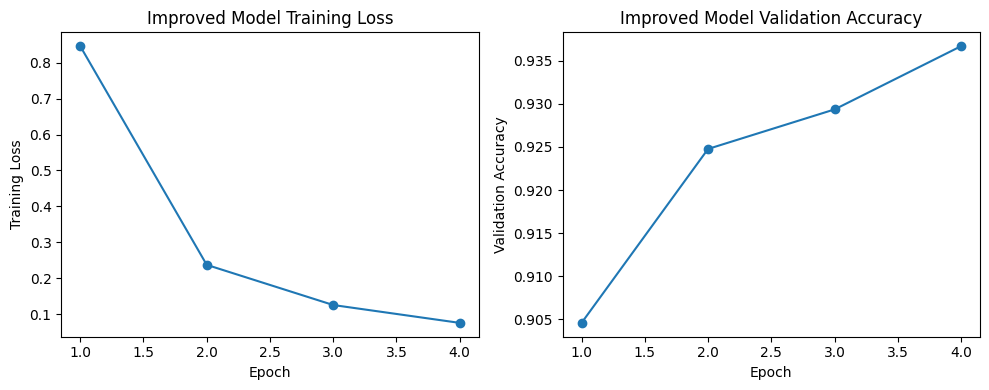

In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from types import SimpleNamespace


def to_xy_from_examples(examples, label_vocab):
    X = [" ".join(ex.text) for ex in examples]
    y = [label_vocab.stoi[ex.label] for ex in examples]
    return X, y


X_tr, y_tr = to_xy_from_examples(train_data.examples, LABEL.vocab)
X_va, y_va = to_xy_from_examples(valid_data.examples, LABEL.vocab)
X_te, y_te = to_xy_from_examples(test_data.examples, LABEL.vocab)

num_labels = len(LABEL.vocab)

# HF tokenizer + tiny collator that returns objects compatible with the helpers
model_name = "distilbert-base-uncased"  # good speed/accuracy tradeoff for TREC
tok = AutoTokenizer.from_pretrained(model_name)


def make_batches(
    X, y, batch_size=32, max_length=64, device=device, shuffle=False, seed=1234
):
    idxs = list(range(len(X)))
    if shuffle:
        g = torch.Generator()
        g.manual_seed(seed)
        idxs = torch.tensor(idxs)[torch.randperm(len(idxs), generator=g)].tolist()

    for start in range(0, len(idxs), batch_size):
        sel = idxs[start : start + batch_size]
        texts = [X[i] for i in sel]
        labels = torch.tensor([y[i] for i in sel], dtype=torch.long, device=device)

        enc = tok(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        inputs = {k: v.to(device) for k, v in enc.items()}  # input_ids, attention_mask
        lengths = inputs["attention_mask"].sum(dim=1).to(device)

        # run_epoch expects: batch.text -> (text, lengths), batch.label -> y
        yield SimpleNamespace(text=(inputs, lengths), label=labels)


class HFSequenceClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.backbone = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        )

    def forward(self, text, lengths=None):
        # text is the dict {input_ids, attention_mask}; lengths unused
        outputs = self.backbone(**text)
        return outputs.logits


hf_model = HFSequenceClassifier(model_name, num_labels).to(device)

opt = torch.optim.AdamW(hf_model.parameters(), lr=2e-5, weight_decay=0.01)


# Tiny adapters so that run_epoch can iterate over the generator "dataloaders"
#    Simple callables that return fresh generators each epoch.
class IterFactory:
    def __init__(self, X, y, batch_size, shuffle):
        self.X, self.y, self.bs, self.shuffle = X, y, batch_size, shuffle

    def __iter__(self):
        return make_batches(self.X, self.y, batch_size=self.bs, shuffle=self.shuffle)


train_iter_hf = IterFactory(X_tr, y_tr, batch_size=32, shuffle=True)
valid_iter_hf = IterFactory(X_va, y_va, batch_size=64, shuffle=False)
test_iter_hf = IterFactory(X_te, y_te, batch_size=64, shuffle=False)

# Train with the helpers
hist_hf, val_hf, ep_hf = train_with_early_stop(
    hf_model,
    train_iter_hf,
    valid_iter_hf,
    optimizer=opt,
    max_epochs=4,
    patience=2,
    loss_fn=criterion_ce,
)
test_hf = run_epoch(hf_model, test_iter_hf)[1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(hist_hf["train_loss"]) + 1), hist_hf["train_loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Improved Model Training Loss")
plt.subplot(1, 2, 2)
plt.plot(range(1, len(hist_hf["val_acc"]) + 1), hist_hf["val_acc"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Improved Model Validation Accuracy")
plt.tight_layout()
plt.show()


In [31]:
print("Transformer test acc:", test_hf)


Transformer test acc: 0.972


In [32]:
# Topic-wise accuracy after improvement
hf_model.eval()
label2idx = LABEL.vocab.stoi
idx2label = {v: k for k, v in label2idx.items()}
per_label_correct = {k: 0 for k in idx2label.keys()}
per_label_total = {k: 0 for k in idx2label.keys()}

with torch.no_grad():
    for batch in test_iter_hf:
        text, lengths = batch.text
        y = batch.label
        logits = hf_model(text, lengths)
        preds = logits.argmax(dim=1)
        for yi, pi in zip(y.tolist(), preds.tolist()):
            per_label_total[yi] += 1
            if yi == pi:
                per_label_correct[yi] += 1

topic_wise_after_transformer = {
    idx2label[i]: per_label_correct[i] / max(1, per_label_total[i])
    for i in per_label_total
}

try:
    print("\nComparison:")
    print("Topic | Part 2(e) | Bi-RNN | Transformer")
    print("-" * 50)
    for topic in ["HUM", "ENTY", "DESC", "NUM", "LOC", "ABBR"]:
        p2_val = (
            topic_wise_acc.get(topic, 0.0) if "topic_wise_acc" in globals() else 0.0
        )
        p3_val = (
            topic_wise_after.get(topic, 0.0) if "topic_wise_after" in globals() else 0.0
        )
        p4_val = (
            topic_wise_after_transformer.get(topic, 0.0)
            if "topic_wise_after_transformer" in globals()
            else 0.0
        )
        print(f"{topic:5s} | {p2_val:8.4f} | {p3_val:8.4f} | {p4_val:13.4f}")
except NameError:
    print("\nNote: Part 2(e) and Part 3(d) results not available for comparison.")


Comparison:
Topic | Part 2(e) | Bi-RNN | Transformer
--------------------------------------------------
HUM   |   0.9077 |   0.9692 |        0.9846
ENTY  |   0.7553 |   0.7234 |        0.9149
DESC  |   0.9638 |   0.9493 |        0.9855
NUM   |   0.8230 |   0.8761 |        0.9823
LOC   |   0.8395 |   0.8272 |        0.9877
ABBR  |   0.7778 |   0.7778 |        1.0000


## Multi-head Self-Attention with Layer Normalization

**Additional Improvement Strategy: Multi-head Self-Attention with Layer Normalization**

- **Multi-head Self-Attention**: Captures different types of relationships between tokens by using multiple attention heads, allowing the model to attend to different aspects of the input simultaneously.

- **Layer Normalization**: Stabilizes training by normalizing activations within each layer, reducing internal covariate shift and improving gradient flow.

- **Benefits**: This approach enhances the model's ability to capture complex dependencies and improves training stability, leading to better generalization.


Epoch 01: train_loss=0.4947 val_acc=0.8211
Epoch 02: train_loss=0.1460 val_acc=0.8459
Epoch 03: train_loss=0.0580 val_acc=0.8394
Epoch 04: train_loss=0.0369 val_acc=0.8358
Epoch 05: train_loss=0.0228 val_acc=0.8468
Epoch 06: train_loss=0.0184 val_acc=0.8422
Epoch 07: train_loss=0.0182 val_acc=0.8413
Epoch 08: train_loss=0.0102 val_acc=0.8413
Epoch 09: train_loss=0.0117 val_acc=0.8532
Epoch 10: train_loss=0.0730 val_acc=0.8303
Epoch 11: train_loss=0.0615 val_acc=0.8495
Epoch 12: train_loss=0.0128 val_acc=0.8450
Epoch 13: train_loss=0.0038 val_acc=0.8606
Epoch 14: train_loss=0.0021 val_acc=0.8505
Epoch 15: train_loss=0.0012 val_acc=0.8587
Epoch 16: train_loss=0.0012 val_acc=0.8569
Epoch 17: train_loss=0.0010 val_acc=0.8587
Multi-head Self-Attention BiGRU test acc: 0.856


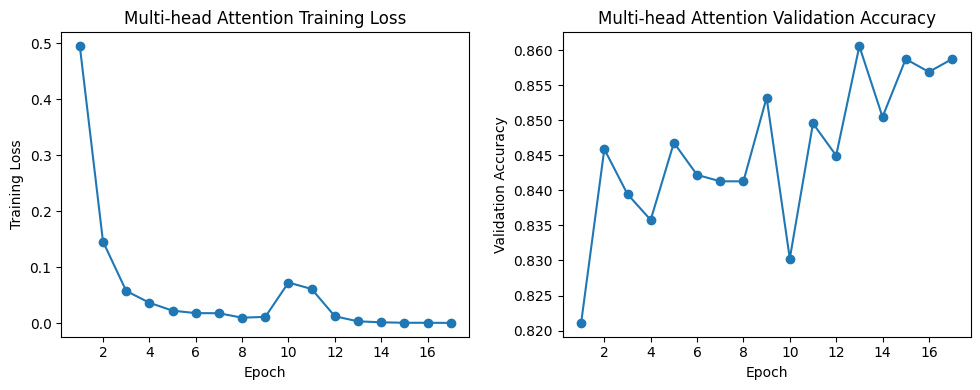

In [33]:
# Multi-head Self-Attention with Layer Normalization
class MultiHeadAttnBiGRU(nn.Module):
    def __init__(self, embedder, hidden=128, layers=2, dropout=0.5, num_heads=4):
        super().__init__()
        self.embedder = embedder
        self.emb_dim = embedder.emb_dim
        self.gru = nn.GRU(
            self.emb_dim,
            hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.0 if layers == 1 else dropout,
        )
        self.hidden_dim = 2 * hidden
        self.num_heads = num_heads
        self.head_dim = self.hidden_dim // num_heads

        # Multi-head attention components
        self.q_proj = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.k_proj = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.v_proj = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.out_proj = nn.Linear(self.hidden_dim, self.hidden_dim)

        # Layer normalization
        self.ln1 = nn.LayerNorm(self.hidden_dim)
        self.ln2 = nn.LayerNorm(self.hidden_dim)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.hidden_dim, num_classes)

    def forward(self, text, lengths):
        text = text.transpose(0, 1)
        emb = self.embedder.forward_token_ids(text)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        gru_out, _ = self.gru(packed)
        gru_out, _ = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)

        # Layer normalization before attention
        gru_out = self.ln1(gru_out)

        # Multi-head self-attention
        batch_size, seq_len, _ = gru_out.size()
        Q = (
            self.q_proj(gru_out)
            .view(batch_size, seq_len, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )
        K = (
            self.k_proj(gru_out)
            .view(batch_size, seq_len, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )
        V = (
            self.v_proj(gru_out)
            .view(batch_size, seq_len, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim**0.5)

        # Mask padding positions
        mask = torch.arange(seq_len, device=text.device)[None, :] < lengths[:, None]
        mask = mask.unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~mask, float("-inf"))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        attn_out = torch.matmul(attn_weights, V)

        # Concatenate heads
        attn_out = (
            attn_out.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_len, self.hidden_dim)
        )
        attn_out = self.out_proj(attn_out)

        # Residual connection and layer normalization
        attn_out = self.ln2(gru_out + attn_out)

        # Global average pooling
        mask = torch.arange(seq_len, device=text.device)[None, :] < lengths[:, None]
        rep = (attn_out * mask.unsqueeze(-1)).sum(1) / lengths.clamp(min=1).unsqueeze(
            -1
        ).float()

        rep = self.dropout(rep)
        return self.fc(rep)


# Train Multi-head Attention model
mh_attn_gru = MultiHeadAttnBiGRU(
    embedder, hidden=128, layers=2, dropout=0.5, num_heads=4
).to(device)
opt_mh = torch.optim.Adam(mh_attn_gru.parameters(), lr=LR, weight_decay=1e-4)

hist_mh, val_mh, ep_mh = train_with_early_stop(
    mh_attn_gru,
    train_iter,
    valid_iter,
    optimizer=opt_mh,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    loss_fn=criterion_ce,
)
test_mh = run_epoch(mh_attn_gru, test_iter)[1]
print("Multi-head Self-Attention BiGRU test acc:", test_mh)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(hist_mh["train_loss"]) + 1), hist_mh["train_loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Multi-head Attention Training Loss")
plt.subplot(1, 2, 2)
plt.plot(range(1, len(hist_mh["val_acc"]) + 1), hist_mh["val_acc"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Multi-head Attention Validation Accuracy")
plt.tight_layout()
plt.show()


**Multi-head Self-Attention for Weak Topic Improvement:**

- **Enhanced Feature Learning**: Multi-head attention allows the model to capture different types of relationships simultaneously, which helps identify subtle patterns in weak topics (ENTY, ABBR, NUM).

- **Better Token Interactions**: By attending to multiple aspects of the input, the model can better understand complex entity relationships and abbreviations that may be challenging for simpler pooling methods.

- **Stabilized Training**: Layer normalization helps maintain stable gradients during training, especially important when dealing with imbalanced topic distributions.


In [34]:
# Topic-wise accuracy for Multi-head Self-Attention model
mh_attn_gru.eval()
per_label_correct_mh = {k: 0 for k in idx2label.keys()}
per_label_total_mh = {k: 0 for k in idx2label.keys()}

with torch.no_grad():
    for batch in test_iter:
        text, lengths = batch.text
        y = batch.label
        logits = mh_attn_gru(text, lengths)
        preds = logits.argmax(dim=1)
        for yi, pi in zip(y.tolist(), preds.tolist()):
            per_label_total_mh[yi] += 1
            if yi == pi:
                per_label_correct_mh[yi] += 1

topic_wise_mh = {
    idx2label[i]: per_label_correct_mh[i] / max(1, per_label_total_mh[i])
    for i in per_label_total_mh
}
print("Topic-wise accuracy with Multi-head Self-Attention:", topic_wise_mh)

# Comparison with Part 2(e) and Part 3(d) if available
try:
    print("\nComparison:")
    print("Topic | Part 2(e) | Bi-RNN | Transformer | Multi-head Attn")
    print("-" * 50)
    for topic in ["HUM", "ENTY", "DESC", "NUM", "LOC", "ABBR"]:
        p2_val = (
            topic_wise_acc.get(topic, 0.0) if "topic_wise_acc" in globals() else 0.0
        )
        p3_val = (
            topic_wise_after.get(topic, 0.0) if "topic_wise_after" in globals() else 0.0
        )
        transformer_val = (
            topic_wise_after_transformer.get(topic, 0.0)
            if "topic_wise_after_transformer" in globals()
            else 0.0
        )
        mh_val = topic_wise_mh.get(topic, 0.0)
        print(
            f"{topic:5s} | {p2_val:8.4f} | {p3_val:8.4f} | {transformer_val:13.4f} | {mh_val:13.4f}"
        )
except NameError:
    print("\nNote: Part 2(e) and Part 3(d) results not available for comparison.")


Topic-wise accuracy with Multi-head Self-Attention: {'HUM': 0.8769230769230769, 'ENTY': 0.7553191489361702, 'DESC': 0.9710144927536232, 'NUM': 0.831858407079646, 'LOC': 0.8024691358024691, 'ABBR': 0.7777777777777778}

Comparison:
Topic | Part 2(e) | Bi-RNN | Transformer | Multi-head Attn
--------------------------------------------------
HUM   |   0.9077 |   0.9692 |        0.9846 |        0.8769
ENTY  |   0.7553 |   0.7234 |        0.9149 |        0.7553
DESC  |   0.9638 |   0.9493 |        0.9855 |        0.9710
NUM   |   0.8230 |   0.8761 |        0.9823 |        0.8319
LOC   |   0.8395 |   0.8272 |        0.9877 |        0.8025
ABBR  |   0.7778 |   0.7778 |        1.0000 |        0.7778
